# Guassian mixture intra-song clustering for identification of "main" beats

If $X_1, \ldots, X_n$ are i.i.d. normal, then the $1 - \alpha$ confidence region is a circle of radius $r$ where
$$P(X_1^2 + \cdots + X_n^2 \leq r^2) =1 - \alpha$$
i.e. given by the square root of the $1-\alpha$ quantile for the chi-squared distribution with $n$ d.f.

A multivariate normal distribution $Y$ with covariance $\Sigma = U S U^t$ is transformed from a standard one $X$ by $Y = AX$ where $A = U S^{1/2}$.  The unit circle is transformed to an ellipse with axes given by the columns of $U$ and axis lengths by $S$.

We default to 95% confidence but I think this might be too strict.

In [1]:
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points
from matplotlib.patches import Ellipse
import scipy, math
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt

## Test on some generated data sets

Generate a single 2d normal distribution

(1000, 2)


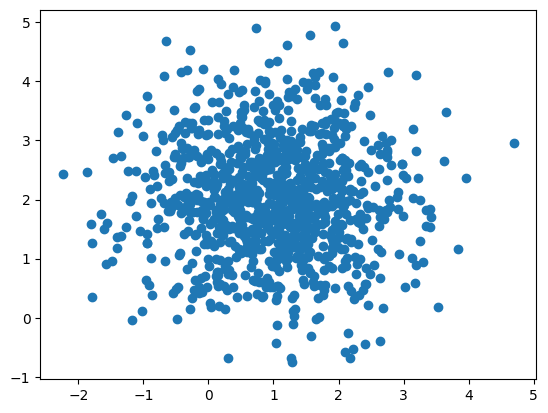

In [2]:
x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)

#x = np.concatenate([x1, x2])
#y = np.concatenate([y1, y2])

x = x1
y = y1

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


[[0.97823245 2.02562975]] [[[ 1.02446011 -0.02624449]
  [-0.02624449  0.95262294]]]
Num covered: 0.903, valid covered: 0.903, overlapped: 0.0


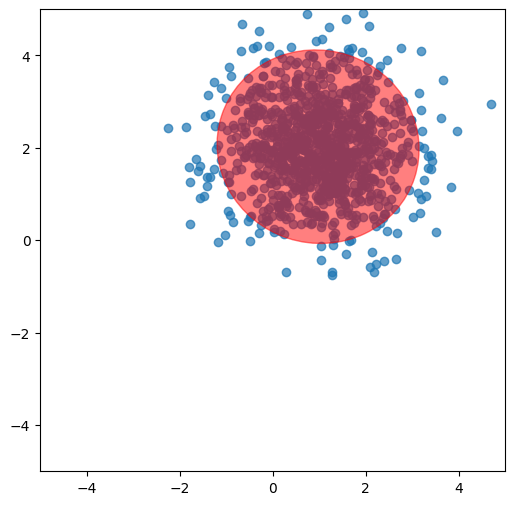

In [3]:
gm = GaussianMixture(n_components=1)


gm.fit(data)

print(gm.means_, gm.covariances_)

#bgm = BayesianGaussianMixture(n_components=2)
#bgm.fit(data)
#print(bgm.means_.shape)

patches, coverage = get_patches(gm, 0.9, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

p = patches[0]

print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")



plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

My conclusion from the below is that the patches "contains points" is buggy as shit.  (Note: comment out the set_axlim to fix at least one bug.)

In [4]:
p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data, confidence=0.90))).sum())

print(data.shape[0])
print(f"patch way: {p.contains_points(data).sum()}")
print(f"my way: {ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()}")


97
1000
patch way: 0
my way: 946


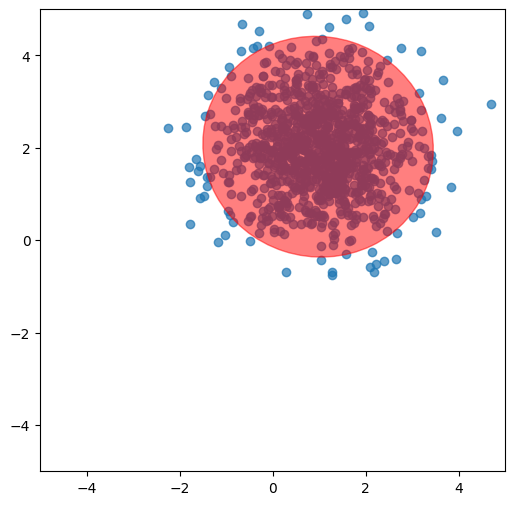

In [5]:
gm = winnow_gm_components(data)
patches, _ = get_patches(gm, 0.95, data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(500, 2)


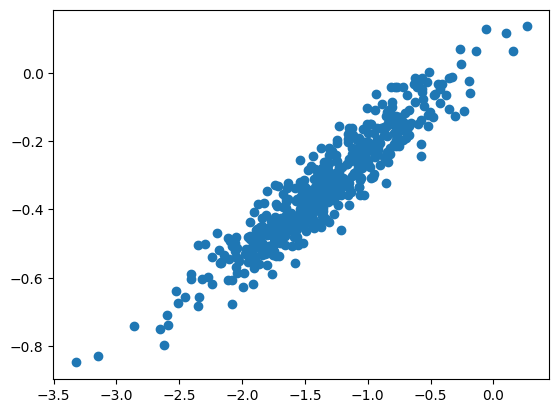

In [6]:
x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
u, s, vh = np.linalg.svd(a)
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


x = x2
y = y2


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)

[[-1.34227882 -0.33398267]] [[[0.2652384  0.079154  ]
  [0.079154   0.02678152]]]
0.946


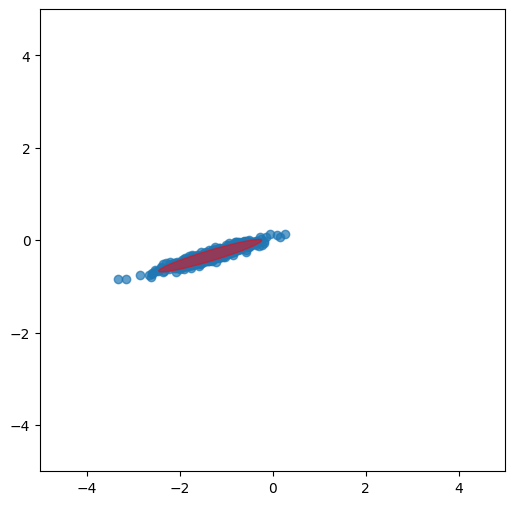

In [7]:
gm = GaussianMixture(n_components=1)
gm.fit(data)
print(gm.means_, gm.covariances_)

patches, coverage = get_patches(gm, 0.9, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


p = patches[0]

print(f"{ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()/data.shape[0]}")


(1500, 2)


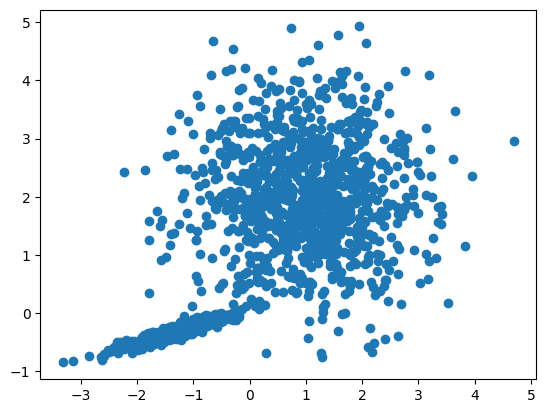

In [8]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



[[ 0.97864168  2.02624976]
 [-1.3409754  -0.3330645 ]] [[[ 1.02461765 -0.02669634]
  [-0.02669634  0.95241382]]

 [[ 0.26674352  0.08016043]
  [ 0.08016043  0.02728824]]]


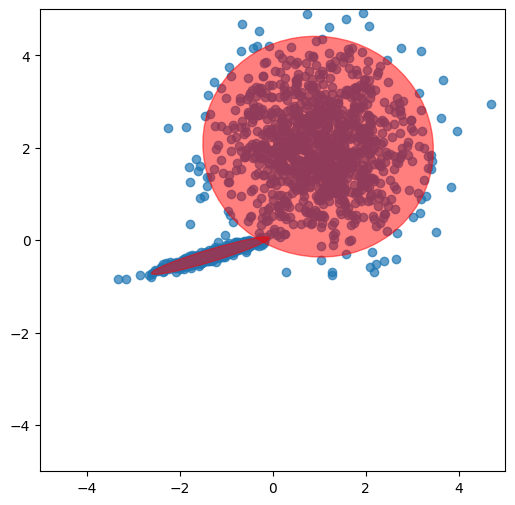

In [9]:
gm = GaussianMixture(n_components=2)
gm.fit(data)
print(gm.means_, gm.covariances_)


# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)

plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

In case we have overlap, the "center" gets shifted a bit.  Not sure if this is desirable or not.

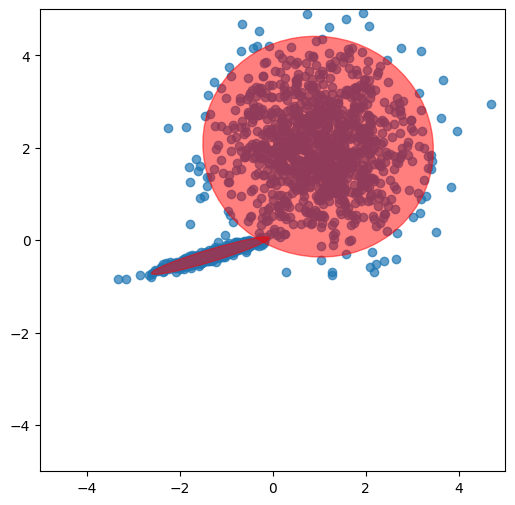

In [10]:
gm = winnow_gm_components(data)


patches, coverage = get_patches(gm, 0.95, data)
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

(1500, 2)


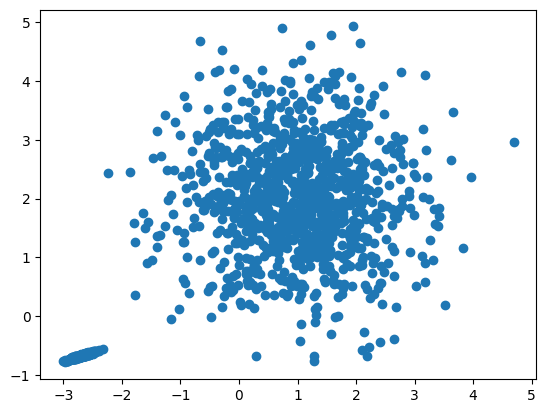

In [11]:
x3 = np.random.normal(loc=-2.0, scale=0.1, size=500)
y3 = np.random.normal(loc=-2.0, scale=0.1, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x3[:, None], y3[:, None]], axis=1) @ a
x3, y3 = v[:,0], v[:,1]


x = np.concatenate([x1, x3])
y = np.concatenate([y1, y3])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



2


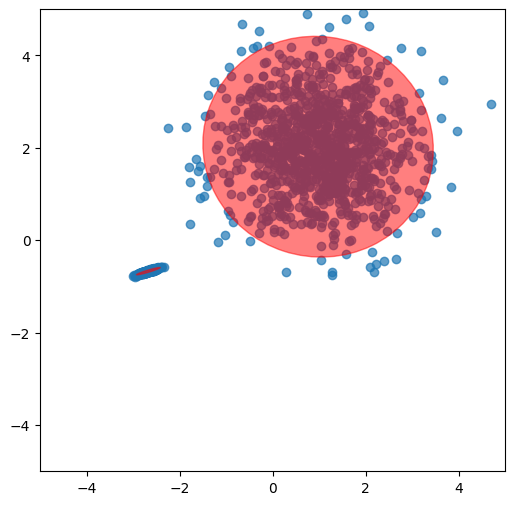

In [12]:
gm = GaussianMixture(n_components=2)
gm.fit(data)


plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

patches, coverage = get_patches(gm, 0.95, data)

plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)


gm = winnow_gm_components(data)
print(gm.means_.shape[0])

### Dumb bug

Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True
False


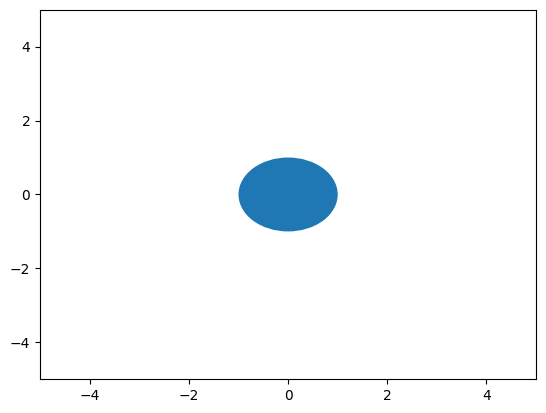

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

## Apply to embedding

The embedding code

In [14]:
def bar_embedding(data,dbeats,bar_num,dimension,framerate,kernel=None, kernel_width=None):
    assert bar_num < len(dbeats), 'bar_num must be smaller than the number of bars in the audio'

    time_interval = (dbeats[bar_num-1],dbeats[bar_num])
    frame_interval = (int(time_interval[0]*framerate), int(time_interval[1]*framerate))

    sub_beats = np.round(np.linspace(frame_interval[0],frame_interval[1],dimension+1))
    sub_beat_interval = int(sub_beats[1] - sub_beats[0])

    if not kernel:
        if not kernel_width:
            kernel_width = 1
        kernel_sigma = kernel_width*sub_beat_interval
        kernel = np.exp(-np.arange(-sub_beat_interval,sub_beat_interval,1)**2/(2*kernel_sigma**2))
        kernel = kernel / np.sum(kernel)
    # print(kernel.shape)

    
    sub_beat_data = [0]*(dimension) # we do not want to count down beat twice
    for i in range(dimension):
        # getting data around subbeat[i] of length 2*sub_beat_length
        # print(sub_beats[i])
        start = int(sub_beats[i]-sub_beat_interval)
        end = int(sub_beats[i]+sub_beat_interval)
        sub_data = np.zeros(2*sub_beat_interval)
        # print(sub_data.shape)
        # print(start,end)
        if start < 0:
            sub_data[-start:] = data[0:end]
        elif end > len(data):
            sub_data[:len(data)-end] = data[start:]
        else:
            sub_data = data[start:end]

        #print(data.shape, sub_data.shape)

        sub_data = sub_data**2
        # print(np.sum(sub_data),np.sum(kernel))
        sub_beat_data[i] = np.sum(kernel*(sub_data))

    return sub_beat_data 



def bar_embedding_opt(data,dbeats,bar_num,dimension,framerate,kernel=None, kernel_width=1):
    assert bar_num < len(dbeats), 'bar_num must be smaller than the number of bars in the audio'

    time_interval = (dbeats[bar_num-1],dbeats[bar_num])
    frame_interval = (int(time_interval[0]*framerate), int(time_interval[1]*framerate))

    sub_beats = np.round(np.linspace(frame_interval[0],frame_interval[1],dimension+1))
    sub_beat_interval = int(sub_beats[1] - sub_beats[0])

    # Shape: (measures, )
    frame_starts = (dbeats[:-1] * framerate).astype(int)
    frame_ends = (dbeats[1:] * framerate).astype(int)
    # Shape: (measures, dimension + 1)
    sub_beats = np.round(np.linspace(frame_starts, frame_ends, dimension+1, axis=1))
    # Shape: (measures, dimension)
    sub_beat_intervals = sub_beats[1:] - sub_beats[:-1]


    kernel_sigma = kernel_width * sub_beat_intervals
    kernel = np.exp(-np.arange(-sub_beat_interval,sub_beat_interval,1)**2/(2*kernel_sigma**2))
    kernel = kernel / np.sum(kernel)
    # print(kernel.shape)
    
    sub_beat_data = np.zeros(dimension) # we do not want to count down beat twice
    sub_data = np.zeros((dimension, 2*sub_beat_interval))

    for i in range(dimension):
        # getting data around subbeat[i] of length 2*sub_beat_length
        start = int(sub_beats[i]-sub_beat_interval)
        end = int(sub_beats[i]+sub_beat_interval)
        sub_data[i, -sub_beat_interval:sub_beat_interval] = data[max(start, 0):min(end, len(data))]


    sub_data = sub_data**2
    return np.sum(kernel * (sub_data), axis=1)

Load the file and process data using the embedding

In [15]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
#from groove.embedding import beat_frames_to_toy
import numpy as np

#file = "milaklaw"
#ext= "mp3"

#file = '03 All the Pretty Girls'
#ext = 'm4a'

#file = '09 D\'Angelo - Spanish Joint'
#ext = 'm4a'

#file = '06 Encore A'
#ext = 'mp3'

file = 'lms'
ext='mp3'

beat_data = get_beat_data(file)
raw, proc, sr = get_audio_data(file, smooth_power, ext=ext)

db = beat_data[beat_data[:,1] == 1, 0]
sub_beat_data = []
for bar_num in range(1,db.shape[0]):
    p = []
    for i in range(4, 5):
        division=2**i
        p.append(np.array(bar_embedding(proc/max(abs(proc)),db,bar_num=bar_num,dimension=division,framerate=sr,kernel_width=1/4)))
    sub_beat_data.append(np.concatenate(p, axis=0))


data = np.stack(sub_beat_data, axis=0)


Some rules for choosing the number of components:
1) Start with some number of components.
2) If overlaps between the 95%ile circles contain more than 10% of points, we should reduce.
3) If any circles don't cover 20%, we reduce.

First, get some statistics on the number of components.

In [16]:
counts = {}
num_trials = 10
for _ in range(num_trials):
    n_components = winnow_gm_components(data, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False).means_.shape[0]
    if n_components in counts:
        counts[n_components] += 1
    else:
        counts[n_components] = 1

print(counts)


# TODO: possible way to improve the alg: do some number of trials to determine number of components based on how "stable" it is, then run it for that number?
# TODO: or, pick the lowest that isn't an outlier?  lower tends to be better
# TODO: also, can take the average of the means?

{3: 6, 4: 2, 2: 2}


For visualization, PCA the top two components and project the clusters down

GaussianMixture(n_components=3)
Weights: [0.25396768 0.31746032 0.428572  ]
PCA values: [0.5260758  0.31787218]


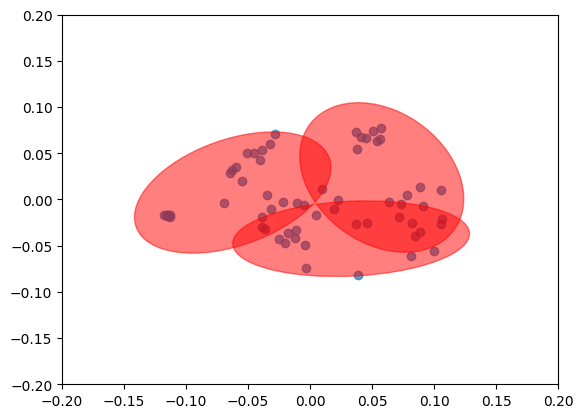

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

gm = winnow_gm_components(data, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False)
print(gm)
print(f"Weights: {gm.weights_}")

pca = PCA(n_components=2)
pca.fit(data)
print(f"PCA values: {pca.singular_values_}")

red_data = pca.transform(data)
patches, _ = get_patches(gm, confidence=0.9, pts=data, pca=pca)

plt.figure()
ax = plt.gca()
ax.set_xlim([-.2, .2])
ax.set_ylim([-.2, .2])


plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
for p in patches:
    ax.add_patch(p)

Pick the measures closest to the means of each cluster and play the audio.

[36 34 50]


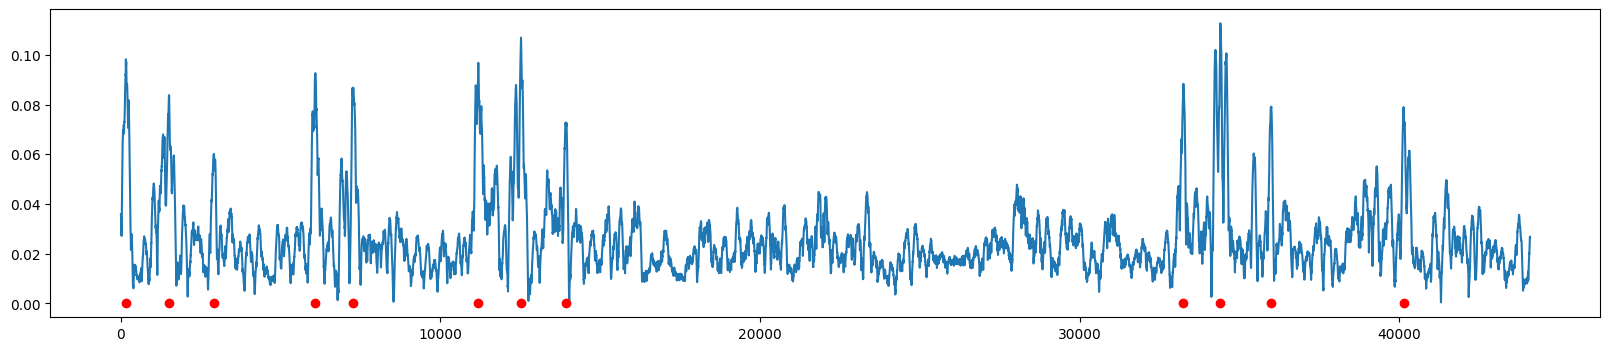

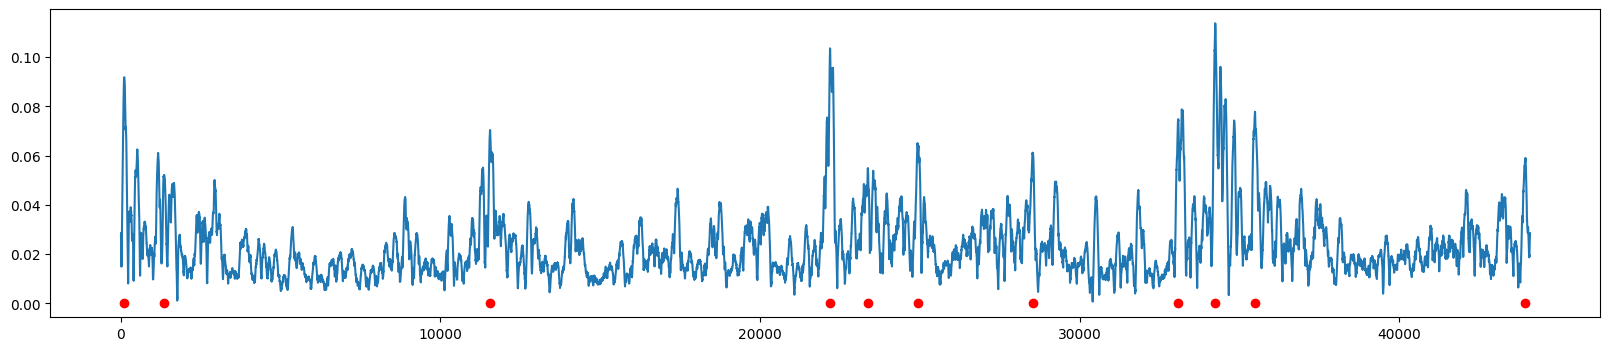

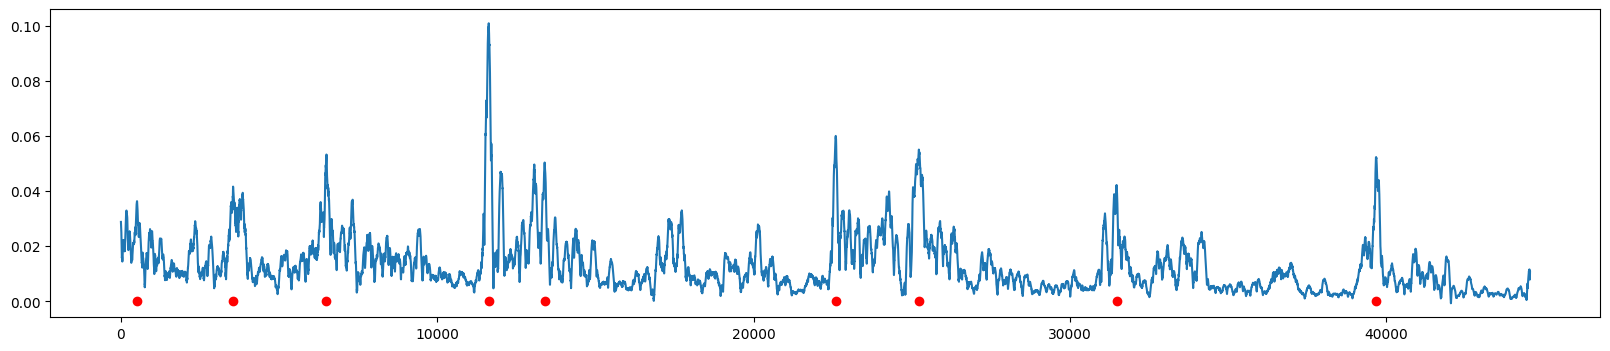

In [19]:
from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa

def find_closest_indices(means, data):
    outs = []
    for i in range(means.shape[0]):
        distances = np.linalg.norm(means[i] - data, axis=1)
        outs.append(distances.argmin(keepdims=True)[0])
    return np.stack(outs)


inds = find_closest_indices(gm.means_, data)
#data[inds]
print(inds)


raw_measures, proc_measures, sr = get_measures(file, smooth_power, ext)
for i in inds:
    raw, proc = raw_measures[i], proc_measures[i]
    beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
    clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


    plt.figure(figsize=(20, 4))
    #plt.plot(raw)
    plt.plot(proc)
    plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
    display(Audio(data=raw, rate=sr))
    #display(Audio(data=raw + clicks, rate=sr))
